In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 73 bytes


In [3]:
!kaggle datasets download -d plameneduardo/sarscov2-ctscan-dataset

100% 230M/230M [00:06<00:00, 38.9MB/s]
100% 230M/230M [00:06<00:00, 36.6MB/s]


In [4]:
from zipfile import ZipFile
file_name = "/content/sarscov2-ctscan-dataset.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [5]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [6]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import keras
from keras.utils.np_utils import to_categorical
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.layers import  Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import Xception
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Input
from keras.models import Model
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from keras import callbacks
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from zipfile import ZipFile

In [7]:
disease_types = ['COVID', 'non-COVID']
# /content/COVID
train_dir = data_dir = '../content'

train_data = []

for index, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append([sp + "/" + file, index, sp])
        
train = pd.DataFrame(train_data, columns = ['File', 'ID','Disease Type'])
train.head()

,File,ID,Disease Type
0,COVID/Covid (692).png,0,COVID
1,COVID/Covid (672).png,0,COVID
2,COVID/Covid (392).png,0,COVID
3,COVID/Covid (44).png,0,COVID
4,COVID/Covid (150).png,0,COVID


In [8]:
IMAGE_SIZE = 150
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) 
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [9]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
X_Train = X_train / 255.
print(X_Train.shape)

2481it [00:10, 230.34it/s]


(2481, 150, 150, 3)


In [10]:
Y_train = train['ID'].values
Y_train = to_categorical(Y_train, num_classes=2)

In [11]:
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.1)

In [12]:
BATCH_SIZE = 64 #64
EPOCHS = 100 #100
SIZE = 150
N_ch=3

In [13]:
def build_resnet50():
    resnet50 = ResNet50(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = resnet50(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(2,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [14]:
model = build_resnet50()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.70, patience=5, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('ResNet50_Model.hdf5', verbose=1, save_best_only=True)
datagen = ImageDataGenerator(rotation_range=360, 
                        width_shift_range=0.2, 
                        height_shift_range=0.2,
                        zoom_range=0.2, 
                        horizontal_flip=True, 
                        vertical_flip=True) 

datagen.fit(X_train)

94765736/94765736 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 3)       84        
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                              

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [15]:
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch= X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=1,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))



<ipython-input-15-b04c1a33be18>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),


Epoch 1/100
34/34 [==============================] - ETA: 0s - loss: 1.0688 - accuracy: 0.5816
Epoch 1: val_loss improved from inf to 0.89488, saving model to ResNet50_Model.hdf5
34/34 [==============================] - 35s 520ms/step - loss: 1.0688 - accuracy: 0.5816 - val_loss: 0.8949 - val_accuracy: 0.5502 - lr: 0.0030
Epoch 2/100
34/34 [==============================] - ETA: 0s - loss: 0.7876 - accuracy: 0.6933
Epoch 2: val_loss did not improve from 0.89488
34/34 [==============================] - 13s 362ms/step - loss: 0.7876 - accuracy: 0.6933 - val_loss: 37.6123 - val_accuracy: 0.5502 - lr: 0.0030
Epoch 3/100
34/34 [==============================] - ETA: 0s - loss: 0.6617 - accuracy: 0.7463
Epoch 3: val_loss did not improve from 0.89488
34/34 [==============================] - 13s 365ms/step - loss: 0.6617 - accuracy: 0.7463 - val_loss: 11.6267 - val_accuracy: 0.4498 - lr: 0.0030
Epoch 4/100
34/34 [==============================] - ETA: 0s - loss: 0.5658 - accuracy: 0.7818
Epoch

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

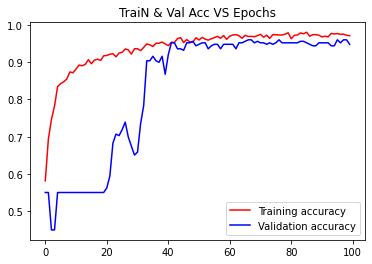

<Figure size 432x288 with 0 Axes>

In [17]:


epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('TraiN & Val Acc VS Epochs')
plt.legend(loc=0)
plt.figure()
plt.show()



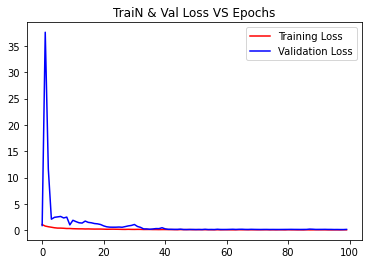

<Figure size 432x288 with 0 Axes>

In [18]:
epochs = range(len(acc))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('TraiN & Val Loss VS Epochs')
plt.legend(loc=0)
plt.figure()
plt.show()

In [19]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import numpy as np


In [20]:
pred = model.predict(X_val)
rounded_labels=np.argmax(pred, axis=1)
rounded_labels_2 = np.argmax(Y_val, axis=1)
rounded_labels[1]
rounded_labels_2[1]
print(accuracy_score(rounded_labels_2,rounded_labels))
print(confusion_matrix(rounded_labels_2,rounded_labels))
print(classification_report(rounded_labels_2,rounded_labels)) 

8/8 [==============================] - 1s 50ms/step
0.9477911646586346
[[130   7]
 [  6 106]]
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       137
           1       0.94      0.95      0.94       112

    accuracy                           0.95       249
   macro avg       0.95      0.95      0.95       249
weighted avg       0.95      0.95      0.95       249



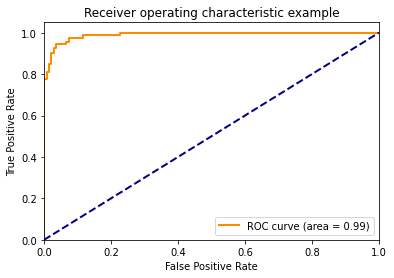

In [21]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(rounded_labels_2, pred[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [22]:
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(Y_val, pred)
print("AUC: ", roc_auc)

AUC:  0.9906152241918664


In [23]:
model.load_weights("ResNet50_Model.hdf5")
model.save("/content/drive/MyDrive/Model Saves/Resnet50 CT-Scan")
score = model.evaluate(X_val,Y_val ,verbose=1)
print('Test Loss:', score[0])
print('Test accuracy:', score[1]*100)

8/8 [==============================] - 0s 58ms/step - loss: 0.1249 - accuracy: 0.9518
Test Loss: 0.1248989924788475
Test accuracy: 95.18072009086609
